# Deep Learning HW3 
@author BAIM Mohamed Jalal, 313551810

In [14]:
import io
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
# Step 1: Load the dataset
path_to_file = tf.keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
)

# Read the text
with open(path_to_file, 'r') as f:
    text = f.read()

# Step 2: Preprocess the data
vocab = sorted(set(text))  # unique characters
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

seq_length = 50
dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_split = 0.2
total_batches = len(dataset)
val_batches = int(total_batches * val_split)

val_dataset = dataset.take(val_batches)
train_dataset = dataset.skip(val_batches)

# SimpleRNN

In [16]:
#Build the Simple RNN model_RNN
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
])

# Define a loss function for BPC
def bpc_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss) / tf.math.log(2.0)

# Compile the model_RNN
model_RNN.compile(optimizer='adam', loss=bpc_loss, metrics = ['accuracy'])

# Callback for breakpoints
class BreakpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, breakpoints, text, num_generate=500):
        self.breakpoints = breakpoints
        self.text = text
        self.num_generate = num_generate

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.breakpoints:
            print(f"\n--- Breakpoint at Epoch {epoch + 1} ---")
            seed_text = self.text[:100]
            generated_text = generate_text(model_RNN, seed_text, self.num_generate)
            print(generated_text)

# Text generation function
def generate_text(model_RNN, start_string, num_generate=500):
    input_eval = [char2idx[c] for c in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    temperature = 1.0

    # Generate predictions character by character
    for _ in range(num_generate):
        predictions = model_RNN(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Add the predicted character to the input
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)


# Train the model_RNN with callbacks for breakpoints
EPOCHS = 50
breakpoints = [10, 20, 30, 40, 49]

history = model_RNN.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[BreakpointCallback(breakpoints, text)]
)

Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2721 - loss: 4.0038 - val_accuracy: 0.4174 - val_loss: 2.8917
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4384 - loss: 2.7717 - val_accuracy: 0.4887 - val_loss: 2.5148
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4950 - loss: 2.4635 - val_accuracy: 0.5176 - val_loss: 2.3324
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5219 - loss: 2.3034 - val_accuracy: 0.5315 - val_loss: 2.2421
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5405 - loss: 2.2007 - val_accuracy: 0.5503 - val_loss: 2.1487
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5525 - loss: 2.1286 - val_accuracy: 0.5557 - val_loss: 2.1039
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5600 - loss: 2.0809 - val_accuracy: 0.5647 - val_loss: 2.0493
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5669 - loss: 2.0387 - val_acc

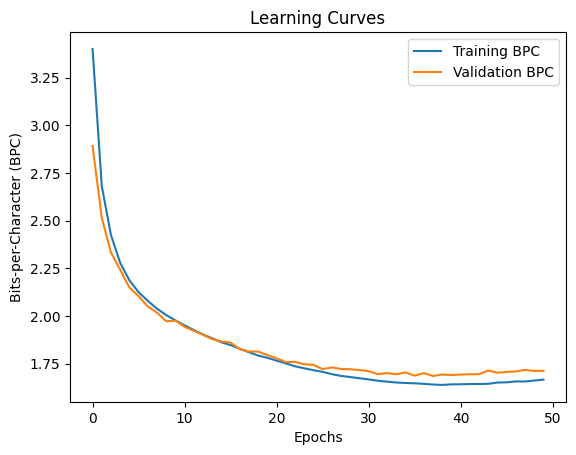

Last train error rate: 0.36826688051223755
Last validation error rate: 0.37609368562698364


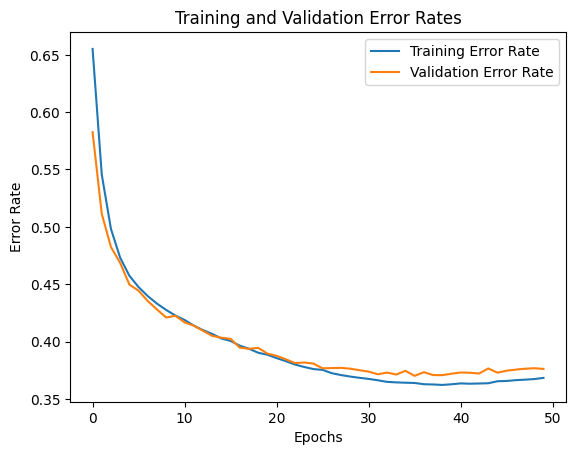

In [17]:
# Plot learning curves
train_bpc = history.history['loss']
val_bpc = history.history['val_loss']

plt.plot(range(EPOCHS), train_bpc, label='Training BPC')
plt.plot(range(EPOCHS), val_bpc, label='Validation BPC')
plt.xlabel('Epochs')
plt.ylabel('Bits-per-Character (BPC)')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Step 6: Calculate and display error rates
train_acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
train_error_rate = [1 - a for a in train_acc]
val_error_rate = [1 - a for a in val_acc]

print("Last train error rate:",train_error_rate[-1])
print("Last validation error rate:",val_error_rate[-1])

plt.plot(range(EPOCHS), train_error_rate, label='Training Error Rate')
plt.plot(range(EPOCHS), val_error_rate, label='Validation Error Rate')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Training and Validation Error Rates')
plt.show()

Training with hidden_units=256, seq_length=50
Training with hidden_units=256, seq_length=100
Training with hidden_units=256, seq_length=200
Training with hidden_units=512, seq_length=50
Training with hidden_units=512, seq_length=100
Training with hidden_units=512, seq_length=200
Training with hidden_units=1024, seq_length=50
Training with hidden_units=1024, seq_length=100
Training with hidden_units=1024, seq_length=200


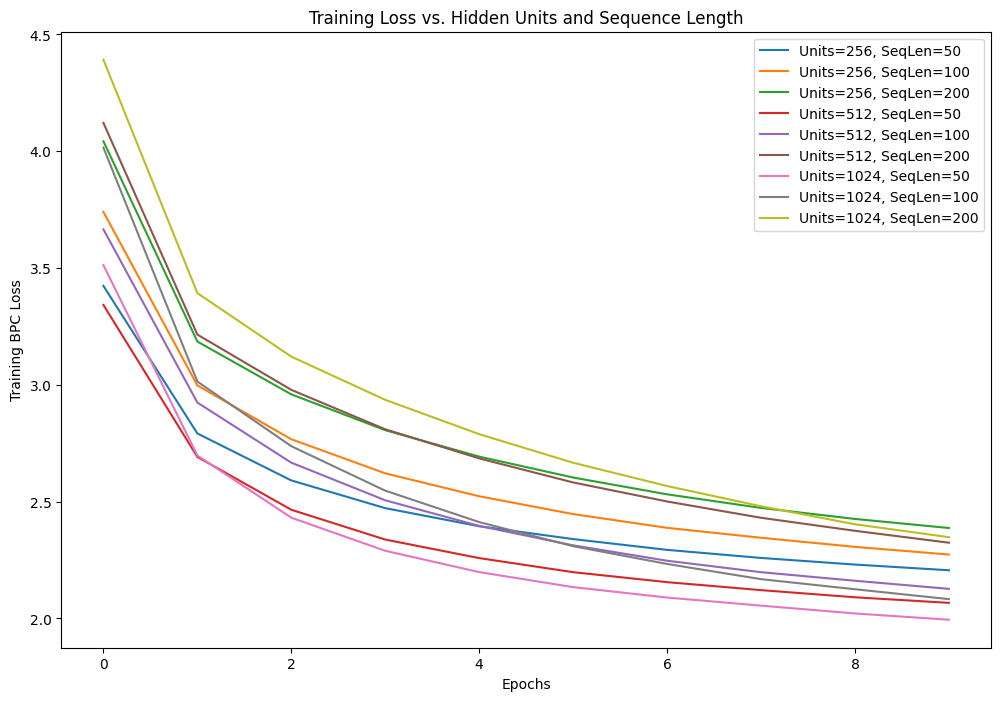

In [18]:
# Training on different hidden units and parameters

def train_rnn(hidden_units, seq_length, epochs=10):
    # Create new dataset with specified sequence length
    sequences = tf.data.Dataset.from_tensor_slices(text_as_int).batch(seq_length + 1, drop_remainder=True)
    sequences = sequences.map(split_input_target)
    dataset = sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    
    val_batches = int(len(dataset) * val_split)
    val_dataset = dataset.take(val_batches)
    train_dataset = dataset.skip(val_batches)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.SimpleRNN(
            units=hidden_units, 
            return_sequences=True, 
            recurrent_initializer='glorot_uniform'
        ),
        tf.keras.layers.Dense(vocab_size)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss=bpc_loss)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=0  # Suppress detailed logs for faster experimentation
    )

    return history.history['loss'], history.history['val_loss']

# Parameter values to test
hidden_sizes = [256, 512, 1024]
sequence_lengths = [50, 100, 200]
EPOCHS = 10

# Results dictionary
results = {}

# Run experiments for each combination of parameters
for hidden_units in hidden_sizes:
    for seq_length in sequence_lengths:
        print(f"Training with hidden_units={hidden_units}, seq_length={seq_length}")
        train_loss, val_loss = train_rnn(hidden_units, seq_length, EPOCHS)
        results[(hidden_units, seq_length)] = (train_loss, val_loss)

# Plot training loss for different configurations
plt.figure(figsize=(12, 8))
for (hidden_units, seq_length), (train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f"Units={hidden_units}, SeqLen={seq_length}")

plt.xlabel('Epochs')
plt.ylabel('Training BPC Loss')
plt.title('Training Loss vs. Hidden Units and Sequence Length')
plt.legend()
plt.show()

## LSTM

In [19]:
# Build the LSTM model_LSTM
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
])

# Compile the model_LSTM
model_LSTM.compile(optimizer='adam', loss=bpc_loss, metrics=["accuracy"])


# Train the model_LSTM with callbacks for breakpoints
EPOCHS = 50
breakpoints = [10, 20, 30, 40, 49]

history_LSTM = model_LSTM.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[BreakpointCallback(breakpoints, text)]
)

Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.2418 - loss: 4.1887 - val_accuracy: 0.4093 - val_loss: 2.9030
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4413 - loss: 2.7388 - val_accuracy: 0.4960 - val_loss: 2.4385
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5101 - loss: 2.3658 - val_accuracy: 0.5378 - val_loss: 2.2152
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5436 - loss: 2.1796 - val_accuracy: 0.5584 - val_loss: 2.0934
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5613 - loss: 2.0738 - val_accuracy: 0.5703 - val_loss: 2.0208
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5731 - loss: 2.0032 - val_accuracy: 0.5800 - val_loss: 1.9636
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5840 - loss: 1.9443 - val_accuracy: 0.5896 - val_loss: 1.9080
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5908 - loss: 1.8999 - 

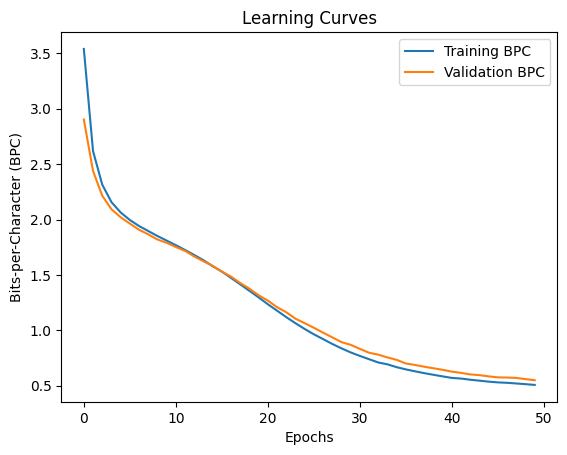

Last train error rate: 0.36826688051223755
Last validation error rate: 0.37609368562698364


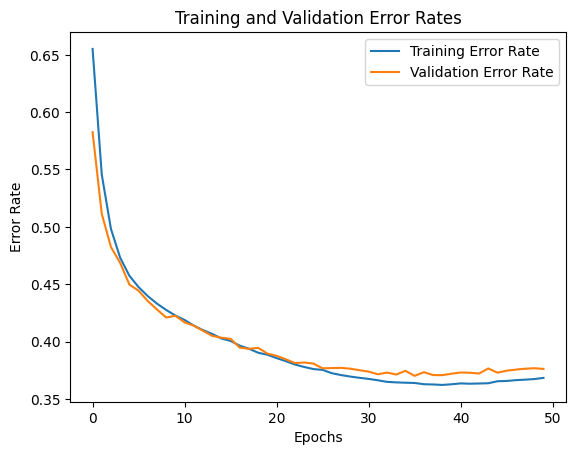

In [20]:
# Plot learning curves
train_bpc = history_LSTM.history['loss']
val_bpc = history_LSTM.history['val_loss']

plt.plot(range(EPOCHS), train_bpc, label='Training BPC')
plt.plot(range(EPOCHS), val_bpc, label='Validation BPC')
plt.xlabel('Epochs')
plt.ylabel('Bits-per-Character (BPC)')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Step 6: Calculate and display error rates
train_acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
train_error_rate = [1 - a for a in train_acc]
val_error_rate = [1 - a for a in val_acc]

print("Last train error rate:",train_error_rate[-1])
print("Last validation error rate:",val_error_rate[-1])


plt.plot(range(EPOCHS), train_error_rate, label='Training Error Rate')
plt.plot(range(EPOCHS), val_error_rate, label='Validation Error Rate')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Training and Validation Error Rates')
plt.show()

Training with hidden_units=256, seq_length=50
Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 3.9387 - val_loss: 2.6810
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2.5277 - val_loss: 2.2639
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2.2058 - val_loss: 2.0826
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 2.0608 - val_loss: 1.9717
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.9667 - val_loss: 1.9021
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.8933 - val_loss: 1.8499
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.8283 - val_loss: 1.7883
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.7747 - val_loss: 1.7301
Epoch 9/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.7107 - val_loss: 1.6886
Epoch 10/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 1.6458 - val_loss: 1.6187
Training with hidden_units=256, seq_length=100
Epoch 1/10
138/138 ━━━━━━━

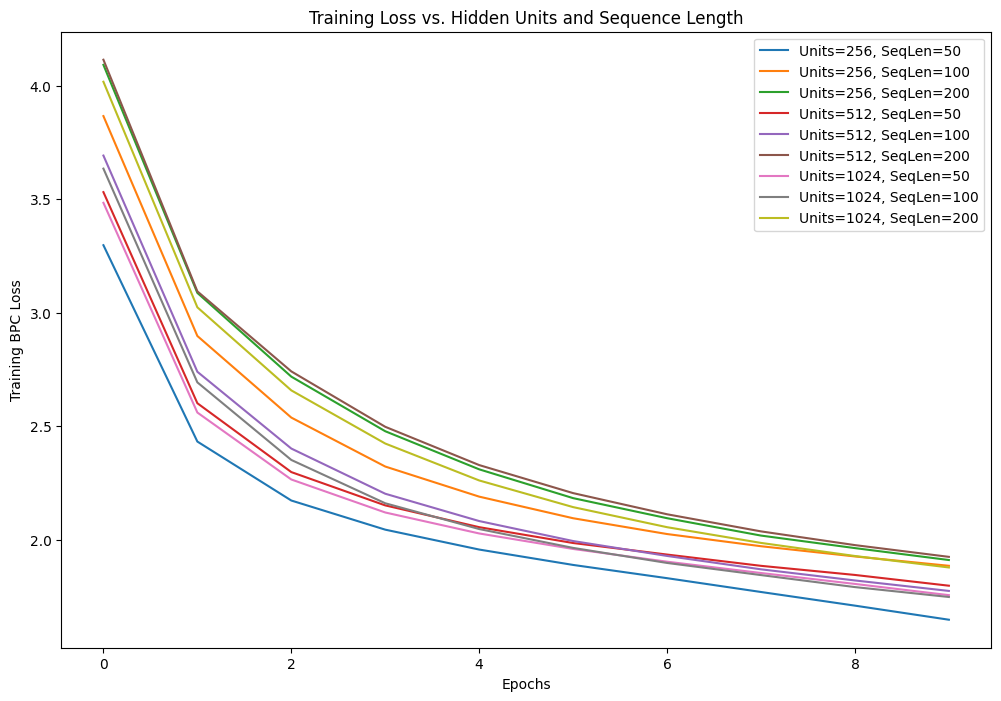

In [21]:
# Training on different hidden units and parameters

def train_rnn(hidden_units, seq_length, epochs=10):
    # Create new dataset with specified sequence length
    sequences = tf.data.Dataset.from_tensor_slices(text_as_int).batch(seq_length + 1, drop_remainder=True)
    sequences = sequences.map(split_input_target)
    dataset = sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    
    val_batches = int(len(dataset) * val_split)
    val_dataset = dataset.take(val_batches)
    train_dataset = dataset.skip(val_batches)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss=bpc_loss)

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1  # Suppress detailed logs for faster experimentation
    )

    return history.history['loss'], history.history['val_loss']

# Parameter values to test
hidden_sizes = [256, 512, 1024]
sequence_lengths = [50, 100, 200]
EPOCHS = 10  # Use fewer epochs for faster comparison

# Results dictionary
results = {}

# Run experiments for each combination of parameters
for hidden_units in hidden_sizes:
    for seq_length in sequence_lengths:
        print(f"Training with hidden_units={hidden_units}, seq_length={seq_length}")
        train_loss, val_loss = train_rnn(hidden_units, seq_length, EPOCHS)
        results[(hidden_units, seq_length)] = (train_loss, val_loss)

# Plot training loss for different configurations
plt.figure(figsize=(12, 8))
for (hidden_units, seq_length), (train_loss, val_loss) in results.items():
    plt.plot(train_loss, label=f"Units={hidden_units}, SeqLen={seq_length}")

plt.xlabel('Epochs')
plt.ylabel('Training BPC Loss')
plt.title('Training Loss vs. Hidden Units and Sequence Length')
plt.legend()
plt.show()

## Priming the model

In [22]:
def priming_model(model, prime_text, char2idx, idx2char, num_generate=500, temperature=1.0):
    """
    Generates text by priming the model with a given input string.

    Args:
        model: Trained LSTM model.
        prime_text (str): Initial text to prime the model.
        char2idx (dict): Character-to-index mapping.
        idx2char (np.array): Index-to-character mapping.
        num_generate (int): Number of characters to generate.
        temperature (float): Sampling temperature for randomness.

    Returns:
        str: Generated text starting with the prime text.
    """
    # Convert the prime text to integer indices
    input_eval = [char2idx[c] for c in prime_text]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    # Generate text character by character
    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        # Adjust the model's confidence with temperature
        predictions = predictions / temperature

        # Sample the next character
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Append the predicted character to the generated text
        text_generated.append(idx2char[predicted_id])

        # Update the input with the last predicted character
        input_eval = tf.expand_dims([predicted_id], 0)

    return prime_text + ''.join(text_generated)

# Use the function to generate text primed with "JULIET"
prime_text = "JULIET"

generated_text_RNN= priming_model(model_RNN, prime_text, char2idx, idx2char, num_generate=1000)
generated_text_LSTM = priming_model(model_LSTM, prime_text, char2idx, idx2char, num_generate=1000)

# Display the generated text
print("RNN:")
print("-"*50)
print(generated_text_RNN)
print('')
print("LSTM")
print("-"*50)
print(generated_text_LSTM)

RNN:
--------------------------------------------------
JULIET:
KENRDULY otou bel.
S: groword:

Sous, be timueinoue: bet lisemomy tlee.
w ot ashal.
tsou,
Thes inor

WAnd.
TRI te.

Ted s,
thong bes t, br lla g Inis haste bu d I hepre ind whe; four.
Frdench stho mu s sake we.
Quche ad--I' anoveiofout dish telenou s.
TIO: shes acar! m trthondosth mnth IUCE odout thou t; s ta e CA t mence.
BRIAPO:
Four w marewnd I as toes
BOR:

Yoncakenve mait tof prd 'sthaicrourese bisam eserdd sa p tu tro secthet br d s tig t b y at; t thr thitrdd thus, se; wawasukn
I t tthapu, picis me hed ad me henax'se, het
Fot, f dre: s okis ed yotest somanso f. thaknarf ir wofapan d, sen, Tourin sent sesee we honfe; T:
Bute pofathed'd! ome l cou alltrind? ove, su d athil t my s.
I t handse aimem th qume?
NANABe:
SHArens ste?
WAspo m cly sof wech WAnu Wer t:
The pre. ye d,
ILENane the KINGAl sweareff ntherethe Is, te s mer; t, thehofusse We d woburk.

Wedind?

t doused y KIZA: ll sid nty tst, fom.
somenoutr yoe,
Noch